In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools

In [56]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [57]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

Timestamp         Price
0    2014-09-17    355.957367
1    2014-09-18    328.539368
2    2014-09-19    307.761139
3    2014-09-20    318.758972
4    2014-09-21    310.632446
...         ...           ...
3503 2024-04-20  59876.710938
3504 2024-04-21  60956.074219
3505 2024-04-22  60919.242188
3506 2024-04-23  62729.296875
3507 2024-04-24  62048.164062

[3508 rows x 2 columns]

In [58]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

Timestamp         Price
0    2021-01-09  32928.058594
1    2021-01-10  31472.685547
2    2021-01-11  29247.208984
3    2021-01-12  27786.228516
4    2021-01-13  30682.929688
...         ...           ...
1054 2023-11-29  34379.074219
1055 2023-11-30  34499.992188
1056 2023-12-01  34625.015625
1057 2023-12-02  35518.437500
1058 2023-12-03  36260.984375

[1059 rows x 2 columns]

In [59]:
def calcola_rendimento_portafoglio_ideale(lista_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [60]:
def estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state):
    # Filtra i dati tra start_date e end_date
    dati_filtrati = dati[(dati['Timestamp'] >= pd.to_datetime(start_date)) & 
                         (dati['Timestamp'] <= pd.to_datetime(end_date))]
    
    # Calcola il numero massimo di periodi non sovrapposti
    num_max_periodi = len(dati_filtrati) - L + 1
    
    # Controlla se è possibile estrarre N periodi diversi
    if num_max_periodi < N:
        raise ValueError(f"Non è possibile estrarre {N} periodi diversi di lunghezza {L} tra le date {start_date} e {end_date}.")
    
    # Inizializza una lista per i periodi estratti e un set per memorizzare gli estremi
    periodi_estratti = []
    estremi_estratti = set()
    
    # Inizializza il generatore di numeri casuali con il seed dato
    rng = np.random.RandomState(random_state)
    
    while len(periodi_estratti) < N:
        # Seleziona un indice casuale per l'inizio del periodo
        indice_inizio = rng.randint(0, len(dati_filtrati) - L + 1)
        
        # Determina gli estremi del periodo
        estremo_inizio = dati_filtrati.iloc[indice_inizio]['Timestamp']
        estremo_fine = dati_filtrati.iloc[indice_inizio + L - 1]['Timestamp']
        
        # Controlla se gli estremi sono già stati utilizzati
        if (estremo_inizio, estremo_fine) not in estremi_estratti:
            # Aggiungi gli estremi al set
            estremi_estratti.add((estremo_inizio, estremo_fine))
            
            # Estrai il periodo e aggiungilo alla lista dei periodi estratti
            periodo = dati_filtrati.iloc[indice_inizio:indice_inizio + L]

            periodo = periodo.reset_index(drop=True)

            periodi_estratti.append(periodo)
    
    return periodi_estratti

In [61]:
# Esempio di utilizzo:
start_date = dati['Timestamp'].iloc[0]
end_date = dati['Timestamp'].iloc[-1]
N = 100 # Numero di periodi da estrarre
L = 60 # Lunghezza di ogni periodo in giorni
random_state = 8

In [62]:
periodi_casuali_esistenti = estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state)
print('Fattore di ritorno medio dei prezzi estratti:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in periodi_casuali_esistenti]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti])

print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

Fattore di ritorno medio dei prezzi estratti: 1.013055361501082
Media dei fattori di rendimento massimi ottenibili: 1.9023948148192946
Punteggio percentuale considerato "sufficiente": 55.57%


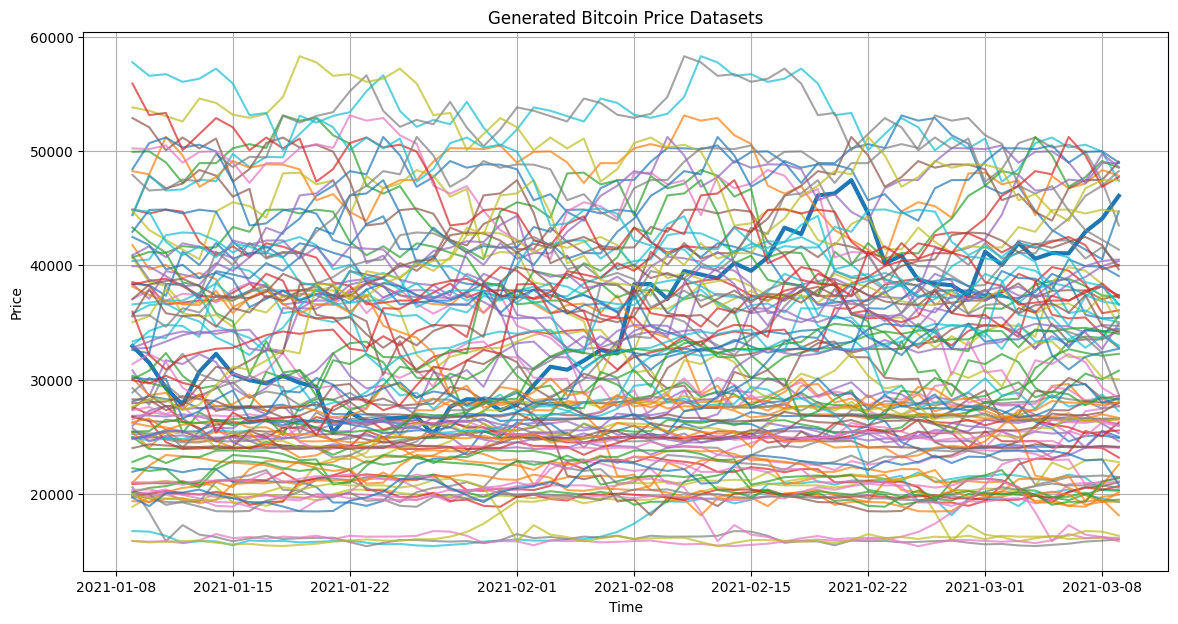

In [63]:
datasets = [periodi_casuali_esistenti[i]['Price'].values for i in range(len(periodi_casuali_esistenti))]

lunghezza_dataset = len(periodi_casuali_esistenti[0])

# Converte i dataset generati in DataFrame
generated_dfs = [pd.DataFrame({'Timestamp': dati['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in datasets] # Fingo che le date siano tutte iniziate con data_inizio

# Plotting
plt.figure(figsize=(14, 7))

# Plot del dataset originale
plt.plot(dati['Timestamp'].iloc[:lunghezza_dataset], dati['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# Plot dei dataset generati
for i, df in enumerate(generated_dfs):
    plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

plt.title('Generated Bitcoin Price Datasets')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.yscale('log')
plt.grid()
# plt.legend()
plt.show()

In [64]:
dati_da_usare = periodi_casuali_esistenti.copy()

## Grid search

In [65]:
def grid_search_trading_strategy(dati_da_usare, strategia, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target):
    """
    Esegue una grid search su una strategia di trading, trovando la migliore combinazione di parametri
    che massimizza un target specifico (rendimento_medio o punteggio_rendimento_medio).
    
    Args:
        dati_da_usare (list): Lista di DataFrame contenenti i dati di prezzo per i vari periodi.
        strategia (function): Strategia di trading da ottimizzare.
        param_combinations (list): Lista delle combinazioni di parametri da testare (ottenuta con itertools.product).
        parametri_fissi (dict, optional): Dizionario di parametri fissi da passare alla strategia. Default è None.
        ind_partenza (int, optional): Indice di partenza per la grid search. Default è 1.
        ind_fine (int, optional): Indice di fine per la grid search. Default è la lunghezza delle combinazioni di parametri.
        target (str, optional): Target da massimizzare ('rendimento_medio' o 'punteggio_rendimento_medio'). Default è 'punteggio_rendimento_medio'.
    
    Returns:
        pd.DataFrame: DataFrame ordinato contenente i risultati della grid search.
    """
    # if parametri_fissi is None:
    #     parametri_fissi = {}

    total_combinations = len(param_combinations)

    # if ind_fine is None:
    #     ind_fine = total_combinations
    
    # Calcola i rendimenti ideali per ogni dataset
    ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[chiave] for chiave in parametri_fissi.keys()])[0] for df in dati_da_usare]

    # Inizializza variabili per tenere traccia delle coppie migliori e peggiori
    best_pair = {'score': -np.inf, 'total_return_factor': -np.inf, 'dataset': None, 'params': None, 'transactions': None}
    worst_pair = {'score': np.inf, 'total_return_factor': np.inf, 'dataset': None, 'params': None, 'transactions': None}

    best_value = -np.inf
    combinazione_max = None
    grid_search_results = []

    saltate = 0
    calcolate = 0

    # Inizia la grid search
    for ind, params in enumerate(param_combinations):
        if ind_partenza <= ind + 1 <= ind_fine:
            parametri_e_valori = [nomi_parametri_variabili[j] + "=" + str(params[j]) for j in range(len(nomi_parametri_variabili))]

            # Verifica se saltare la combinazione
            if condizioni_salto[ind]:
                print(f'Salto la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) perchè sarebbe identica a una combinazione già vista...\n')
                saltate += 1
                continue

            print(f"Sto calcolando la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) ({calcolate} calcolate, {saltate} saltate)...")
            calcolate += 1
            
            # Lista per conservare i rendimenti per ogni dataset
            total_return_factors = []

            for i, df in enumerate(dati_da_usare):
                transactions = strategia(df, **{**dict(zip(nomi_parametri_variabili, params)), **parametri_fissi})
                portfolio_values = transactions['valore_totale_portafoglio']
                total_return_factor = portfolio_values.iloc[-1] / portfolio_values[0]
                total_return_factors.append(total_return_factor)
                
                # punteggio_rendimento = total_return_factor / ideal_returns[i]
                
                # Gestisci il best/worst se necessario (facoltativo)
                # Calcola il punteggio rendimento
                punteggio_rendimento = total_return_factor / ideal_returns[i]
                # Aggiorna la coppia migliore e peggiore
                if punteggio_rendimento > best_pair['score']:
                    best_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}
                if punteggio_rendimento < worst_pair['score']:
                    worst_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}

            rendimento_medio = np.mean(total_return_factors)
            punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
            
            # Salva i risultati
            grid_search_results.append({
                **dict(zip(nomi_parametri_variabili, params)),
                'rendimento_medio': rendimento_medio,
                'punteggio_rendimento_medio': punteggio_rendimento_medio
            })

            print(f'Fattore Rendimento Medio: {rendimento_medio}')
            print(f'Punteggio rendimento medio: {punteggio_rendimento_medio}')
            
            # Aggiorna il valore massimo
            current_value = punteggio_rendimento_medio if target == 'punteggio_rendimento_medio' else rendimento_medio
            if current_value > best_value:
                best_value = current_value
                alternative_value = rendimento_medio if target == 'punteggio_rendimento_medio' else punteggio_rendimento_medio
                combinazione_max = parametri_e_valori
                ind_max = ind
            
            if target == 'punteggio_rendimento_medio':
                print(f'Punteggio rendimento medio migliore trovato finora (combinazione {ind_max+1}): {best_value}, con fattore rendimento medio {alternative_value} e parametri {combinazione_max}\n')
            else:
                print(f'Fattore rendimento medio migliore trovato finora (combinazione {ind_max+1}): {best_value}, con punteggio rendimento medio {alternative_value} e parametri {combinazione_max}\n')

    # Converte i risultati in DataFrame e ordina
    grid_search_results_df = pd.DataFrame(grid_search_results)
    sorted_results_df = grid_search_results_df.sort_values(by=target, ascending=False)
    
    return sorted_results_df, best_pair, worst_pair

#### Grid search su media pesata forzata dinamica

In [66]:
# def strategia_media_pesata_forzata_dinamica(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto):

#     liquidita_mobile = liquidita_mobile_iniziale
#     liquidita_fissa = liquidita_fissa_iniziale
#     bitcoin = bitcoin_iniziali

#     ultima_azione_effettiva = None
#     ultimi_acquisti = []
#     transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
#     giorni_acquisto = []
#     giorni_vendita = []

#     prezzo_massimo = 0
#     in_salita = False

#     def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
#         nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
#         ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
#         nuova_transazione = pd.DataFrame({
#             'Data': [dati['Timestamp'].iloc[i]],
#             'Numero giorno': i,
#             'Prezzo': [dati['Price'].iloc[i]],
#             'Ultima Azione': [ultima_azione],
#             'Azione Attuale': [azione],
#             '% acquisto/vendita di LM': [perc],
#             'Quantità in € Comprata/Venduta': [quantita_euro],
#             'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
#             'Liquidità Mobile': [liquidita_mobile],
#             'Liquidità Fissa': [liquidita_fissa],
#             'Bitcoin Posseduti': [bitcoin],
#             'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
#         })
#         transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
#         if azione != "-":
#             ultima_azione_effettiva = azione

#     def primo_acquisto(i):
#         nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
#         quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
#         bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
#         liquidita_mobile -= quantita_primo_acquisto
#         bitcoin += bitcoin_acquistati
#         ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
#         giorni_acquisto.append(i)
#         aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

#     def calcola_prezzo_medio_pesato():
#         return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])
    
#     def calculate_rsi(prices):
#         if len(prices) < 2:
#             raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

#         # Calcola le variazioni di prezzo
#         price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
        
#         # Separa i guadagni e le perdite
#         gains = [max(change, 0) for change in price_changes]
#         losses = [abs(min(change, 0)) for change in price_changes]

#         # Calcola la media dei guadagni e delle perdite
#         avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
#         avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

#         rsi = 100 * avg_gain / (avg_gain + avg_loss)

#         return rsi

#     def lunghezza_media_salite_discese_consecutive(prices):
#         if len(prices) < 1:
#             raise ValueError("La lista dei prezzi deve contenere almeno 1 elemento per calcolare il numero medio di salite e discese consecutive.")

#         up_lengths = []
#         down_lengths = []

#         current_trend = None
#         count = 0

#         for i in range(1, len(prices)):
#             if prices.iloc[i] > prices.iloc[i-1]:  # Salita
#                 if current_trend == 'up':
#                     count += 1
#                 else:
#                     if current_trend == 'down':
#                         down_lengths.append(count)
#                     current_trend = 'up'
#                     count = 1
#             elif prices.iloc[i] < prices.iloc[i-1]:  # Discesa
#                 if current_trend == 'down':
#                     count += 1
#                 else:
#                     if current_trend == 'up':
#                         up_lengths.append(count)
#                     current_trend = 'down'
#                     count = 1

#         # Aggiungi l'ultima sequenza
#         if current_trend == 'up':
#             up_lengths.append(count)
#         elif current_trend == 'down':
#             down_lengths.append(count)

#         return np.mean(up_lengths) if not np.isnan(np.mean(up_lengths)) else 0, np.mean(down_lengths) if not np.isnan(np.mean(down_lengths)) else 0


#     def mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto):
#         # perc_prima_vendita_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_salite ** i for i in range(len(coefficienti_acquisto)))
#         perc_primo_acquisto_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_discese ** i for i in range(len(coefficienti_acquisto)))

#         # if lunghezza_media_salite == 0:
#         #     perc_prima_vendita_risultante = 1
#         # else:
#         #     perc_prima_vendita_risultante = 2**(-lunghezza_media_salite+1)

#         # if lunghezza_media_discese == 0:
#         #     perc_primo_acquisto_risultante = 1
#         # else:
#         #     perc_primo_acquisto_risultante = 2**(-lunghezza_media_discese+1)

#         return min(1, perc_primo_acquisto_risultante)

#     # Primo acquisto al giorno 1
#     primo_acquisto(1)

#     for i in range(2, len(dati)):
#         if vendita_immediata_dinamica:
#             if metodo == 'rsi':
#                 if i < tempo_rsi:
#                     dati_parziali = dati[:i]
#                 else:
#                     dati_parziali = dati[i-tempo_rsi:i]

#                 rsi = calculate_rsi(dati_parziali['Price'])

#                 if rsi > soglia_rsi:
#                     vendita_immediata = False
#                 else:
#                     vendita_immediata = True
#             elif metodo == 'salite_discese_consecutive':
#                 if i < tempo_salite_discese_consecutive:
#                     dati_parziali = dati[:i]
#                 else:
#                     dati_parziali = dati[i-tempo_salite_discese_consecutive:i]

#                 salite_discese_consecutive = lunghezza_media_salite_discese_consecutive(dati_parziali['Price'])
#                 lunghezza_media_salite = salite_discese_consecutive[0]
#                 lunghezza_media_discese = salite_discese_consecutive[1]

#                 perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto)

#                 if lunghezza_media_salite > soglia_salite_consecutive:
#                     vendita_immediata = False
#                 else:
#                     vendita_immediata = True

#                 # if lunghezza_media_discese > soglia_discese_consecutive:
#                 #         _ , perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_salite, lunghezza_media_discese, coefficienti_acquisto, coefficienti_vendita)

#             else:
#                 raise ValueError("Metodo scelto non valido")


#         prezzo_oggi = dati['Price'].iloc[i]
#         prezzo_ieri = dati['Price'].iloc[i-1]
#         prezzo_laltro_ieri = dati['Price'].iloc[i-2]
#         azione = "-"  # Inizializziamo l'azione come nulla
        
#         if bitcoin > 0:
#             prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
#             # Aggiorna il prezzo massimo se siamo in una salita
#             if prezzo_oggi > prezzo_ieri:
#                 in_salita = True
#                 if prezzo_ieri < prezzo_laltro_ieri:
#                     prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
#                 prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
#             else:
#                 in_salita = False
            
#             if vendita_immediata:
#                 if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
#                     # Vendita immediata
#                     quantita_venduta = bitcoin
#                     ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
#                     if ricavo >= min_vendita:
#                         liquidita_mobile += ricavo
#                         bitcoin = 0
#                         giorni_vendita.append(i)
#                         azione = 'Vendita'
#                         aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
#                         # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
#                         ultimi_acquisti = []
#             else:
#                 if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
#                     # Vendita con stop-loss
#                     quantita_venduta = bitcoin
#                     ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
#                     if ricavo >= min_vendita:
#                         liquidita_mobile += ricavo
#                         bitcoin = 0
#                         giorni_vendita.append(i)
#                         azione = 'Vendita (Stop-Loss)'
#                         aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
#                         # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
#                         ultimi_acquisti = []
        
#         if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
#             if not ultimi_acquisti:
#                 if prezzo_oggi < prezzo_ieri:
#                     # Primo acquisto dopo una vendita
#                     primo_acquisto(i)
#                     azione = 'Primo Acquisto'
#                     # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
#             elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
#                 # Calcolo del prezzo desiderato di acquisto
#                 ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
#                 A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

#                 # Calcolo della quantità da acquistare
#                 S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
#                 P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
#                 quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

#                 if quantita_da_acquistare_euro >= min_acquisto:
#                     if quantita_da_acquistare_euro > liquidita_mobile:
#                         # Usa la liquidità fissa se necessario
#                         liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
#                         liquidita_mobile += liquidita_aggiuntiva
#                         liquidita_fissa -= liquidita_aggiuntiva

#                     if quantita_da_acquistare_euro <= liquidita_mobile:
#                         # Acquisto
#                         bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
#                         vecchia_liquidita_mobile = liquidita_mobile
#                         liquidita_mobile -= quantita_da_acquistare_euro
#                         bitcoin += bitcoin_acquistati
#                         ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
#                         giorni_acquisto.append(i)
#                         azione = 'Acquisto'
#                         aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

#                     elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
#                         # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
#                         bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
#                         vecchia_liquidita_mobile = liquidita_mobile
#                         liquidita_mobile = 0
#                         bitcoin += bitcoin_acquistati
#                         ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
#                         giorni_acquisto.append(i)
#                         azione = 'Acquisto'
#                         aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
#         if azione == "-":
#             # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
#             aggiorna_transazioni(i, azione, 0, 0, 0)

#     return transazioni

In [67]:
# # Parametri da variare nella grid search
# perc_primo_acquisto_values = [0.1, 0.3, 0.5]
# vendita_immediata_values = [True, False]
# perc_sbilanciamento_acquisto_values = [0.5, 0.7, 0.9]
# soglia_minima_acquisto_values = [0, 0.05, 0.1]
# soglia_minima_vendita_values = [-0.3, 0, 0.3]
# perc_stop_loss_values = [0, 0.1, 0.2]
# compra_pure_values = [True, False]
# vendita_immediata_dinamica_values = [True, False] # Valutare se usare il numero medio di salite consecutive anzichè l'rsi
# tempo_rsi_values = [3, 7, 14]
# soglia_rsi_values = [25, 50, 75] # Percentuale già moltiplicata per 100, quindi è un numero da 0 a 100!
# metodo_values = ['rsi', 'salite_discese_consecutive']
# tempo_salite_discese_consecutive_values = [7, 14, 21]
# soglia_salite_consecutive_values = [1, 1.5, 2] # Numeri reali >= 1
# coefficienti_acquisto_values = [[1, 0.5, -0.625, 0.125], # mappa 0 in 1, 1 in 1, 2 in 0.5, 3 in 0.25
#                                 [0.5, 1.41667, -1.125, 0.208333], # mappa 0 in 0.5, 1 in 1, 2 in 0.5, 3 in 0.25
#                                  [0.5, 2.69129, -3.91627, 2.39463, -0.81746, 0.166656, -0.0201416, 0.00133076, -0.0000370086]] # mappa 0 in 0.5, 1 in 1, 2 in 0.5, 3 in 0.25, 4 in 0.125, 5 in 0.0625, 6 in 1/32, 7 in 1/64, 8 in 1/128

# lista_values = [perc_primo_acquisto_values, vendita_immediata_values, perc_sbilanciamento_acquisto_values, soglia_minima_acquisto_values, soglia_minima_vendita_values, perc_stop_loss_values, compra_pure_values, vendita_immediata_dinamica_values, tempo_rsi_values, soglia_rsi_values, metodo_values, tempo_salite_discese_consecutive_values, soglia_salite_consecutive_values, coefficienti_acquisto_values]

In [68]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidita_mobile_iniziale': 1000,
#     'liquidita_fissa_iniziale': 0,
#     'bitcoin_iniziali': 0,
#     'perc_commissione_acquisto': 0.001,
#     'perc_commissione_vendita': 0.001,
#     'min_acquisto': 5,
#     'min_vendita': 5
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['perc_primo_acquisto', 'vendita_immediata', 'perc_sbilanciamento_acquisto', 'soglia_minima_acquisto', 'soglia_minima_vendita', 
#                        'perc_stop_loss', 'compra_pure', 'vendita_immediata_dinamica', 'tempo_rsi', 'soglia_rsi', 'metodo', 
#                        'tempo_salite_discese_consecutive', 'soglia_salite_consecutive', 'coefficienti_acquisto']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto = params

#                 condizione = not vendita_immediata_dinamica and (tempo_rsi != tempo_rsi_values[0] or soglia_rsi != soglia_rsi_values[0] or metodo != metodo_values[0] or tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0]) or vendita_immediata_dinamica and vendita_immediata != vendita_immediata_values[0] or perc_primo_acquisto == 1 and (perc_sbilanciamento_acquisto != perc_sbilanciamento_acquisto_values[0] or soglia_minima_acquisto != soglia_minima_acquisto_values[0] or compra_pure != compra_pure_values[0]) or vendita_immediata and perc_stop_loss != perc_stop_loss_values[0] or metodo != 'salite_discese_consecutive' and (tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)         

# target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e fattore_rendimento_medio

# # Esegui la grid search
# sorted_results_df = grid_search_trading_strategy(dati_da_usare, strategia_media_pesata_forzata_dinamica, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target)

#### Grid search su trading a potenze con matrice

In [79]:
def normalizza_matrice(matrice, exception_cells):
    """
    Normalizza una matrice tenendo conto delle celle da escludere.
    """
    # Creiamo una copia della matrice originale per evitare modifiche in-place
    matrice = matrice.copy()
    
    # Imposta a zero le celle in exception_cells
    for cella in exception_cells:
        matrice[cella[0], cella[1]] = 0

    # Normalizza la matrice in modo che la somma delle celle sia 1
    somma_totale = np.sum(matrice)
    
    if somma_totale == 0:
        raise ValueError("La somma delle celle nella matrice, escluse le eccezioni, è 0. Non è possibile normalizzare.")
    
    matrice /= somma_totale
    return matrice

def trading_potenze_con_matrice(dati, righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure, liquidità_iniziale, bitcoin_iniziali):
    if not matrice_liquidità[0]:
        matrice_liquidità = np.full((righe, colonne), 1 / (righe * colonne))

    if not matrice_bitcoin[0]:
        matrice_bitcoin = np.full((len(matrice_liquidità), len(matrice_liquidità[0])), 1 / (len(matrice_liquidità) *  len(matrice_liquidità[0])))

    # Controllo sugli max_exp_acquisto e max_exp_vendita
    if not (isinstance(max_exp_acquisto, int) and max_exp_acquisto <= 0):
        raise ValueError("max_exp_acquisto deve essere un intero non positivo.")
    if not (isinstance(max_exp_vendita, int) and max_exp_vendita <= 0):
        raise ValueError("max_exp_vendita deve essere un intero non positivo.")
    
    # Convertiamo i dati di input in numpy array per efficienza
    matrice_liquidità = np.array(matrice_liquidità)
    matrice_bitcoin = np.array(matrice_bitcoin)
    
    # Controlli iniziali: Verifichiamo che la somma delle celle faccia 1
    if not np.isclose(np.sum(matrice_liquidità), 1) or not np.isclose(np.sum(matrice_bitcoin), 1):
        raise ValueError("Le matrici non sono normalizzate correttamente, la somma delle loro celle deve essere 1.")
    
    if base_acquisto < 1 or base_vendita < 1:
        raise ValueError("Attenzione! base_vendita e base_acquisto devono essere entrambi almeno 1.")
    
    # Normalizzazione delle matrici se ci sono eccezioni
    if exception_cells:
        matrice_liquidità = normalizza_matrice(matrice_liquidità, exception_cells)
        matrice_bitcoin = normalizza_matrice(matrice_bitcoin, exception_cells)
    
    # Estrazione dei dati sui prezzi
    prezzi = dati['Price'].values
    date = dati['Timestamp'].values
    
    # Inizializzo le quantità parziali di liquidità e bitcoin per ogni strategia
    liquidità_parziale = matrice_liquidità * liquidità_iniziale
    bitcoin_parziale = matrice_bitcoin * bitcoin_iniziali
    
    # Mantengo una copia della liquidità dopo l'ultima ridistribuzione, se necessario
    liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale) if riferimento_iniziale_acquisto else None
    
    # DataFrame per tenere traccia delle transazioni giornaliere
    transazioni_giornaliere = []
    
    # Variabili per tenere traccia di stato acquisto/vendita per ogni strategia
    acquisto_contatori = np.zeros_like(matrice_liquidità)
    vendita_contatori = np.zeros_like(matrice_bitcoin)
    prezzo_medio_acquisto = np.zeros_like(matrice_bitcoin)
    euro_spesi_acquisto = np.zeros_like(matrice_bitcoin)  # Tieni traccia degli euro spesi durante l'ultima scia di acquisti
    in_scia_acquisto = np.zeros_like(matrice_bitcoin, dtype=bool)  # Flag per indicare se siamo in una scia di acquisti
    
    # Loop sui giorni
    for giorno in range(1, len(prezzi)):  # Inizia da 1 perché confrontiamo con il giorno precedente
        prezzo_corrente = prezzi[giorno]
        prezzo_precedente = prezzi[giorno - 1]
        
        # Calcolo la liquidità e i bitcoin totali all'inizio del giorno
        liquidità_inizio_giorno = np.sum(liquidità_parziale)
        bitcoin_inizio_giorno = np.sum(bitcoin_parziale)
        
        # Variabili per tenere traccia delle transazioni giornaliere
        euro_spesi_giorno = 0
        euro_guadagnati_giorno = 0
        bitcoin_guadagnati_giorno = 0
        bitcoin_venduti_giorno = 0
        
        # Loop su tutte le strategie
        for i in range(matrice_liquidità.shape[0]):
            for j in range(matrice_liquidità.shape[1]):
                if (i, j) in exception_cells:
                    continue
                
                # Acquisto: Se il prezzo scende e ho liquidità
                if prezzo_corrente < prezzo_precedente:
                    # Determina la liquidità di riferimento
                    if riferimento_iniziale_acquisto:
                        liquidità_riferimento = liquidità_iniziale_ridistribuzione[i, j]
                    else:
                        liquidità_riferimento = liquidità_parziale[i, j]
                    
                    # Determina la percentuale di acquisto in base alla progressione geometrica
                    percentuale_acquisto = min(base_acquisto ** max_exp_acquisto, base_acquisto ** (max_exp_acquisto - i + acquisto_contatori[i, j]))
                    euro_da_spendere = percentuale_acquisto * liquidità_riferimento
                    
                    # Se la liquidità da spendere è maggiore della liquidità attuale
                    if euro_da_spendere > liquidità_parziale[i, j]:
                        if compra_pure:
                            euro_acquisto = liquidità_parziale[i, j]  # Spendi tutto quello che hai
                        else:
                            continue  # Non comprare niente
                    else:
                        euro_acquisto = euro_da_spendere
                    
                    # Aggiorna liquidità e bitcoin
                    liquidità_parziale[i, j] -= euro_acquisto
                    bitcoin_acquistati = euro_acquisto / prezzo_corrente
                    bitcoin_parziale[i, j] += bitcoin_acquistati
                    
                    # Aggiorna il prezzo medio pesato degli acquisti solo per la scia corrente
                    euro_spesi_acquisto[i, j] += euro_acquisto
                    prezzo_medio_acquisto[i, j] = (
                        prezzo_medio_acquisto[i, j] * (euro_spesi_acquisto[i, j] - euro_acquisto) + euro_acquisto * prezzo_corrente
                    ) / euro_spesi_acquisto[i, j]
                    
                    # Aggiorna il contatore degli acquisti e delle transazioni giornaliere
                    acquisto_contatori[i, j] += 1
                    euro_spesi_giorno += euro_acquisto
                    bitcoin_guadagnati_giorno += bitcoin_acquistati
                    vendita_contatori[i, j] = 0  # Reset contatore vendite per nuova discesa
                
                # Vendita: Se il prezzo sale e ho bitcoin
                elif prezzo_corrente > prezzo_precedente and bitcoin_parziale[i, j] > 0:
                    # Verifica se il prezzo corrente supera il prezzo medio pesato dell'ultima scia di acquisti
                    if prezzo_corrente > prezzo_medio_acquisto[i, j] * (1 + soglia_vendita):
                        # Reset della scia di acquisti e inizio della scia di vendite
                        in_scia_acquisto[i, j] = False

                        percentuale_vendita = min(base_vendita ** max_exp_vendita, base_vendita ** (max_exp_vendita - j + vendita_contatori[i, j]))
                        bitcoin_da_vendere = percentuale_vendita * bitcoin_parziale[i, j]
                        
                        # Aggiorna bitcoin e liquidità
                        bitcoin_parziale[i, j] -= bitcoin_da_vendere
                        euro_venduti = bitcoin_da_vendere * prezzo_corrente
                        liquidità_parziale[i, j] += euro_venduti
                        
                        # Aggiorna le transazioni giornaliere
                        euro_guadagnati_giorno += euro_venduti
                        bitcoin_venduti_giorno += bitcoin_da_vendere
                        
                        # Incrementa il contatore delle vendite
                        vendita_contatori[i, j] += 1
                        acquisto_contatori[i, j] = 0  # Reset contatore acquisti per nuova salita
        
        # Calcolo le percentuali di liquidità e bitcoin usati per le transazioni
        percentuale_liquidità_usata = euro_spesi_giorno / liquidità_inizio_giorno if liquidità_inizio_giorno > 0 else 0
        percentuale_bitcoin_venduti = bitcoin_venduti_giorno / bitcoin_inizio_giorno if bitcoin_inizio_giorno > 0 else 0
        
        # Calcolo il valore del portafoglio totale alla fine del giorno
        valore_liquidità_totale = np.sum(liquidità_parziale)
        numero_totale_bitcoin = np.sum(bitcoin_parziale)
        valore_bitcoin_totale = numero_totale_bitcoin * prezzo_corrente
        valore_totale_giornaliero = valore_liquidità_totale + valore_bitcoin_totale
        
        # Salvo i dati delle transazioni giornaliere
        transazioni_giornaliere.append({
            'data': date[giorno],
            'prezzo': prezzo_corrente,
            'euro spesi': euro_spesi_giorno,
            'euro guadagnati': euro_guadagnati_giorno,
            'bitcoin venduti': bitcoin_venduti_giorno,
            'bitcoin guadagnati': bitcoin_guadagnati_giorno,
            'percentuale liquidità usata': percentuale_liquidità_usata,
            'percentuale bitcoin venduti': percentuale_bitcoin_venduti,
            'liquidità totale': valore_liquidità_totale,
            'bitcoin totali': numero_totale_bitcoin,
            'valore bitcoin totali': valore_bitcoin_totale,
            'valore_totale_portafoglio': valore_totale_giornaliero
        })
        
        # Ogni "giorni_ridistribuzione" giorni, facciamo la ridistribuzione
        if (giorno + 1) % giorni_ridistribuzione == 0:
            # Somma totale di liquidità e bitcoin attuali
            liquidità_totale = np.sum(liquidità_parziale)
            bitcoin_totale = np.sum(bitcoin_parziale)
            
            # Ridistribuisco la liquidità e i bitcoin parziali in base alle matrici
            liquidità_parziale = matrice_liquidità * liquidità_totale
            bitcoin_parziale = matrice_bitcoin * bitcoin_totale
            
            # Se riferimento_iniziale_acquisto è True, aggiorno la liquidità di riferimento
            if riferimento_iniziale_acquisto:
                liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale)

    # Converto le transazioni giornaliere in un DataFrame
    df_transazioni = pd.DataFrame(transazioni_giornaliere)
    
    return df_transazioni

In [82]:
righe_values = [2, 3, 4]
colonne_values = [1, 2, 3]
matrice_liquidità_values = [[[]], [[0.01, 0.01], [0.49, 0.49]], [[0.49, 0.49], [0.01, 0.01]]] # Per eventuali valori vuoti viene creata una matrice uniforme dall'algoritmo di trading (con dimensioni righe x colonne)
matrice_bitcoin_values = [[[]]] # Per eventuali valori vuoti viene creata una matrice uniforme dall'algoritmo di trading (con dimensioni uguali a matrice_liquidità)
exception_cells_values = [[]] # [[], [(0, 0)], [(0, 0), (1, 0)], [(1, 0)]] # Assicurarsi che esistano le celle indicate per tutte le combinazioni
giorni_ridistribuzione_values = [3, 7, 10]
base_acquisto_values = [1.0001, 1.001, 1.01]
base_vendita_values = [1.01, 1.1, 2]
soglia_vendita_values = [-np.inf, -1, -0.5]
max_exp_acquisto_values = [0, -1, -2, -3]
max_exp_vendita_values = [0, -1, -2]
riferimento_iniziale_acquisto_values = [True, False]
compra_pure_values = [True, False]

lista_values = [righe_values, colonne_values, matrice_liquidità_values, matrice_bitcoin_values, exception_cells_values, giorni_ridistribuzione_values, base_acquisto_values, base_vendita_values, soglia_vendita_values, max_exp_acquisto_values, max_exp_vendita_values, riferimento_iniziale_acquisto_values, compra_pure_values]

In [83]:
# Definisci i parametri fissi
parametri_fissi = {
    'liquidità_iniziale': 1000,
    'bitcoin_iniziali': 0
}

# Genera tutte le combinazioni dei parametri variabili
nomi_parametri_variabili = ['righe', 'colonne', 'matrice_liquidità', 'matrice_bitcoin', 'exception_cells', 'giorni_ridistribuzione', 'base_acquisto', 'base_vendita', 'soglia_vendita', 'max_exp_acquisto', 'max_exp_vendita', 'riferimento_iniziale_acquisto', 'compra_pure']

param_combinations = list(itertools.product(*lista_values))

ind_partenza = 1
ind_fine = len(param_combinations)

# Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
condizioni_salto = []
for ind, params in enumerate(param_combinations):
            if ind_partenza <= ind + 1 <= ind_fine:
                righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure = params

                condizione = not riferimento_iniziale_acquisto and compra_pure != compra_pure_values[0] or matrice_liquidità[0] and (righe != righe_values[0] or colonne != colonne_values[0]) or matrice_bitcoin[0] and (righe != righe_values[0] or colonne != colonne_values[0])

                condizioni_salto.append(condizione)
            else:
                condizioni_salto.append(None)         

target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e punteggio_rendimento_medio

# Esegui la grid search
sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_potenze_con_matrice, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target)

# Punteggio rendimento medio migliore trovato finora (combinazione 19026): 0.5666487976068822, con fattore rendimento medio 1.07550289395134 e parametri ['righe=3', 'colonne=1', 'matrice_liquidità=[[]]', 'matrice_bitcoin=[[]]', 'exception_cells=[]', 'giorni_ridistribuzione=7', 'base_acquisto=1.001', 'base_vendita=1.1', 'soglia_vendita=-inf', 'max_exp_acquisto=-1', 'max_exp_vendita=-1', 'riferimento_iniziale_acquisto=True', 'compra_pure=False']

Sto calcolando la combinazione 1/104976 (['righe=2', 'colonne=1', 'matrice_liquidità=[[]]', 'matrice_bitcoin=[[]]', 'exception_cells=[]', 'giorni_ridistribuzione=3', 'base_acquisto=1.0001', 'base_vendita=1.01', 'soglia_vendita=-inf', 'max_exp_acquisto=0', 'max_exp_vendita=0', 'riferimento_iniziale_acquisto=True', 'compra_pure=True']) (0 calcolate, 0 saltate)...
Fattore Rendimento Medio: 1.0468522984249775
Punteggio rendimento medio: 0.5509941012572718
Punteggio rendimento medio migliore trovato finora (combinazione 1): 0.5509941012572718, con fattore rendimento medio 1.0468522984249775 e parametri ['righe=2', 'colonne=1', 'matrice_liquidità=[[]]', 'matrice_bitcoin=[[]]', 'exception_cells=[]', 'giorni_ridistribuzione=3', 'base_acquisto=1.0001', 'base_vendita=1.01', 'soglia_vendita=-inf', 'max_exp_acquisto=0', 'max_exp_vendita=0', 'riferimento_iniziale_acquisto=True', 'compra_pure=True']

Sto calcolando la combinazione 2/104976 (['righe=2', 'colonne=1', 'matrice_liquidità=[[]]', 'matrice

In [ ]:
def plot_transactions(df, transactions, title):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    transactions['data'] = pd.to_datetime(transactions['data'])
    
    plt.figure(figsize=(20, 7))
    plt.grid()
    plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
    acquisti = transactions[transactions['azione'].isin(['acquisto'])]
    vendite = transactions[transactions['azione'].isin(['vendita'])]
    
    # Calcolo delle dimensioni dei punti
    max_acquisto = acquisti['quantità_euro'].max()
    max_vendita = vendite['quantità_euro'].max()
    
    def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
        return min_size + (max_size - min_size) * (quantita / max_quantita)
    
    # Rimuovi eventuali NaN o infiniti
    # acquisti = acquisti.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    # vendite = vendite.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    
    dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
    dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
    # Verifica che tutte le dimensioni siano corrette
    assert len(acquisti['data']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
    assert len(vendite['data']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
    if not acquisti.empty:
        plt.scatter(acquisti['data'], acquisti['prezzo'], 
                    s=dimensioni_acquisti, 
                    color='green', alpha=0.6, label='Acquisti')
    
    if not vendite.empty:
        plt.scatter(vendite['data'], vendite['prezzo'], 
                    s=dimensioni_vendite, 
                    color='red', alpha=0.6, label='Vendite')
    
    plt.title(title)
    plt.xlabel('data')
    plt.ylabel('prezzo')
    plt.legend()
    plt.show()


Miglior coppia:
Dataset: 81
Parametri: ['percentuale_sbilanciamento_acquisti=0.95', 'percentuale_sbilanciamento_vendite=0.9', 'percentuale_primo_acquisto=0.007', 'percentuale_prima_vendita=0.002', 'vendi_pure=True', 'compra_pure=True', 'soglia_minima_vendita=0.5']
Fattore di rendimento totale: 1.3403655923404274
Punteggio: 0.9580985005002377


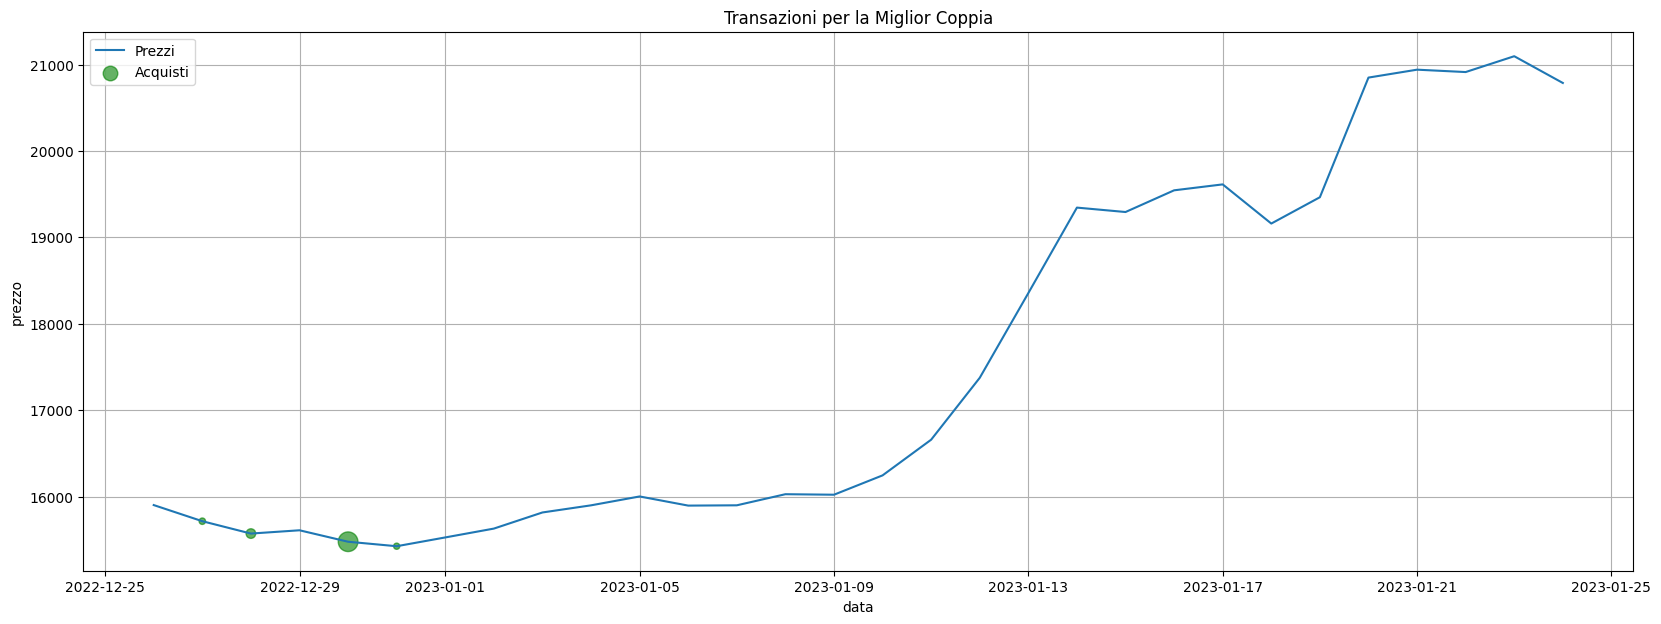


Elenco transazioni per la miglior coppia:


data        prezzo    azione ultima azione  \
0 2022-12-27  15716.216797  acquisto      acquisto   
1 2022-12-28  15573.189453  acquisto      acquisto   
3 2022-12-30  15478.656250  acquisto      acquisto   
4 2022-12-31  15426.750000  acquisto      acquisto   

  percentuale_liquidità_usata  percentuale_token_venduti  quantità_euro  \
0     (0.7000000000000001, 2)                          0            7.0   
1      (13.39375629405841, 2)                          0          133.0   
3                  (100.0, 2)                          0          860.0   
4                           0                          0            0.0   

   quantità_bitcoin  liquidità_posseduta  bitcoin_posseduti  \
0          0.000445                993.0           0.000445   
1          0.008532                860.0           0.008977   
3          0.055505                  0.0           0.064482   
4          0.000000                  0.0           0.064482   

   valore_totale_portafoglio  
0                 999.993000  
1                 999.796359  
3                 998.087760  
4                 994.740765

In [ ]:
# Stampa e visualizza i risultati per la coppia migliore
print("\nMiglior coppia:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Parametri: {best_pair['params']}")
print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
print(f"Punteggio: {best_pair['score']}")
plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la Miglior Coppia')
print("\nElenco transazioni per la miglior coppia:")
best_pair['transactions'][best_pair['transactions']['azione'] != '-']


Peggior coppia:
Dataset: 55
Parametri: ['percentuale_sbilanciamento_acquisti=0.99', 'percentuale_sbilanciamento_vendite=0.9', 'percentuale_primo_acquisto=0.015', 'percentuale_prima_vendita=0.002', 'vendi_pure=True', 'compra_pure=True', 'soglia_minima_vendita=0.5']
Fattore di rendimento totale: 0.6340958258276205
Punteggio: 0.4208306681822747


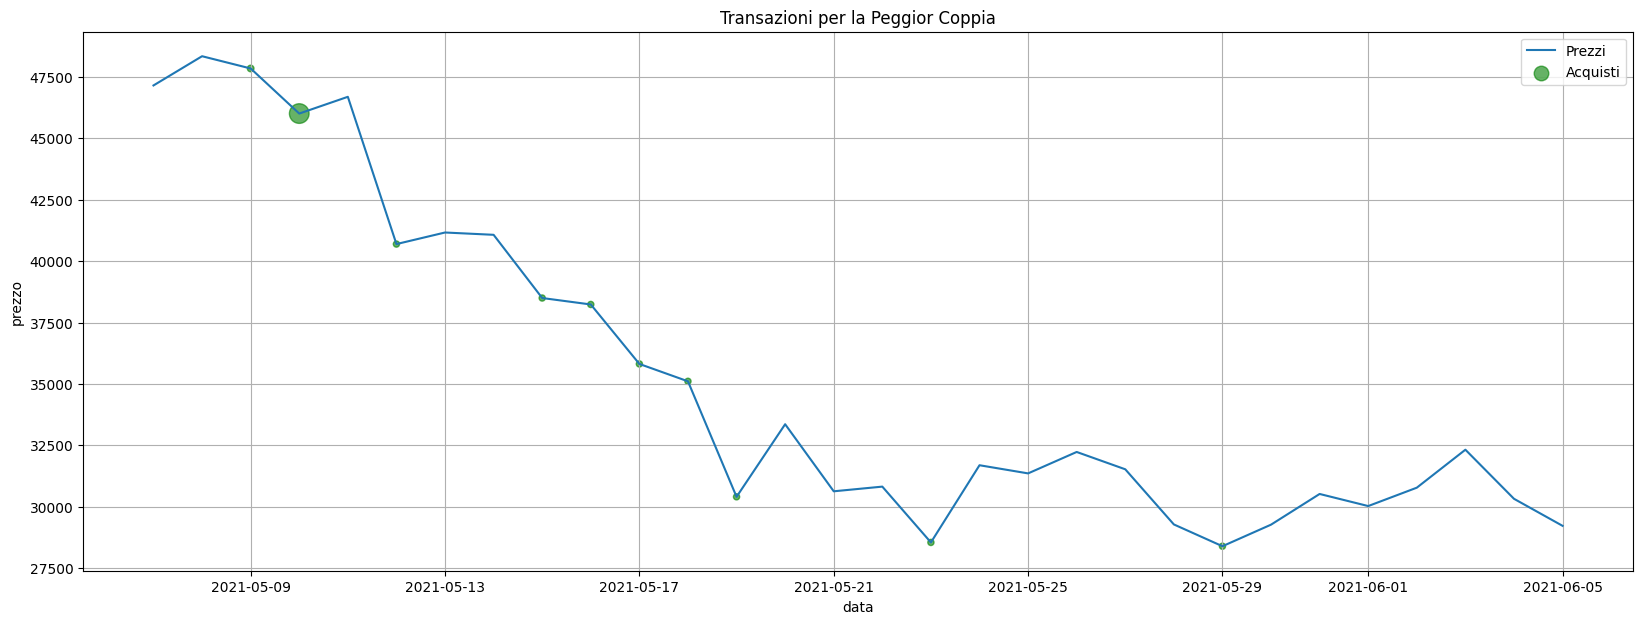


Elenco transazioni per la peggior coppia:


data        prezzo    azione ultima azione  \
1  2021-05-09  47846.523438  acquisto      acquisto   
2  2021-05-10  46010.484375  acquisto      acquisto   
4  2021-05-12  40695.511719  acquisto      acquisto   
7  2021-05-15  38498.738281  acquisto      acquisto   
8  2021-05-16  38235.890625  acquisto      acquisto   
9  2021-05-17  35814.085938  acquisto      acquisto   
10 2021-05-18  35106.796875  acquisto      acquisto   
11 2021-05-19  30403.203125  acquisto      acquisto   
15 2021-05-23  28545.537109  acquisto      acquisto   
21 2021-05-29  28391.164062  acquisto      acquisto   

   percentuale_liquidità_usata  percentuale_token_venduti  quantità_euro  \
1                     (1.5, 2)                          0           15.0   
2                   (100.0, 2)                          0          985.0   
4                            0                          0            0.0   
7                            0                          0            0.0   
8                            0                          0            0.0   
9                            0                          0            0.0   
10                           0                          0            0.0   
11                           0                          0            0.0   
15                           0                          0            0.0   
21                           0                          0            0.0   

    quantità_bitcoin  liquidità_posseduta  bitcoin_posseduti  \
1           0.000313                985.0           0.000313   
2           0.021387                  0.0           0.021700   
4           0.000000                  0.0           0.021700   
7           0.000000                  0.0           0.021700   
8           0.000000                  0.0           0.021700   
9           0.000000                  0.0           0.021700   
10          0.000000                  0.0           0.021700   
11          0.000000                  0.0           0.021700   
15          0.000000                  0.0           0.021700   
21          0.000000                  0.0           0.021700   

    valore_totale_portafoglio  
1                  999.985000  
2                  998.424973  
4                  883.090359  
7                  835.420497  
8                  829.716717  
9                  777.163689  
10                 761.815556  
11                 659.747831  
15                 619.436581  
21                 616.086694

In [ ]:
# Stampa e visualizza i risultati per la coppia peggiore
print("\nPeggior coppia:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Parametri: {worst_pair['params']}")
print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
print(f"Punteggio: {worst_pair['score']}")
plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la Peggior Coppia')
print("\nElenco transazioni per la peggior coppia:")
worst_pair['transactions'][worst_pair['transactions']['azione'] != '-']